# Speech-based Emotion Recognition for Voice Comms.
## Main Notebook

Datasets used:

*   RAVDESS, CREMA-D
*   See AugmentData.ipynb for augmentation scripts  

Models:
* Pytorch MLP
* Example sklearn RandomForest, MLP

In [1]:
import soundfile # read audio files
import numpy as np
import librosa # extract features
import glob
import os
import pickle # to save model after training
import time

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch
from torch import nn
import torch.optim as optim

# if torch.cuda.is_available():
#     torch.backends.cudnn.deterministic = True

from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing, metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split # for splitting training and testing data
from sklearn.utils import shuffle

import seaborn as sn
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.font_manager import FontProperties
%matplotlib inline

# Data handling, feature extract

In [2]:
#device setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def extract_feature(file_name):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32") # all depth 32bit float
        sample_rate = sound_file.samplerate # always 16kHz
        
        # pre-emphasis
        pre_emphasis = 0.97
        X = np.append(X[0], X[1:] - pre_emphasis * X[:-1])

        # remove silence
        y = librosa.effects.split(X, top_db=20)
        l = []
        for i in y:
            l.append(X[i[0]:i[1]] )
        X = np.concatenate(l, axis=0)
        
        # extract features
        hop_length=int(0.100*sample_rate)
        n_fft=int(0.500*sample_rate)
        mfccs = librosa.feature.mfcc(y=X, 
                                     sr=sample_rate, 
                                     n_mfcc=40, 
                                     n_mels=40,
                                     power=2.0,
                                     window = 'hamming',
                                     fmin = 0,
                                     fmax = 8000,
                                     hop_length=hop_length,
                                     n_fft=n_fft,
                                     win_length=n_fft,
                                     center=True)  
    return mfccs[1:]

In [4]:
# all emotions RAVDESS
int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# all emotions CREMA-D
cemotion = {
    "NEU": "neutral",
    "HAP": "happy",
    "SAD": "sad",
    "ANG": "angry",
    "FEA": "fearful",
    "DIS": "disgust",
}

# all emotions TESS
tessemotion = {
    "neutral.wav": "neutral",
    "happy.wav": "happy",
    "sad.wav": "sad",
    "angry.wav": "angry",
    "fear.wav": "fearful",
    "disgust.wav": "disgust",
    "ps.wav": "surprised",
}

# all emotions SAVEE
saveeemotion = {
    "n": "neutral",
    "h": "happy",
    "s": "sad",
    "a": "angry",
    "f": "fearful",
    "d": "disgust",
    "p": "surprised",
}

# allow only these emotions from dataset(s)
AVAILABLE_EMOTIONS = {
    "neutral",
    "calm", # only included in RAVDESS
    "happy",
    "sad",
    "angry", 
    "fearful",
    "disgust",
    "surprised" # in TESS specifies pleasant surprise
}

# allow only these emotions from dataset(s) for wild test
AVAILABLE_EMOTIONS_TEST = {
    "neutral",
    #"calm", # only included in RAVDESS
    "happy",
    "sad",
    "angry", 
    "fearful",
    "disgust",
    #"surprised" # in TESS specifies pleasant surprise
}

# map emotion to dimensional model space
circumplex_model = {
    "neutral":[(0.0, 0.0),"tab:grey"],
    "calm":[(0.5, -0.7),"tab:cyan"], # only included in RAVDESS
    "happy":[(0.8, 0.1),"tab:purple"],
    "sad":[(-0.8, -0.3),"tab:blue"],
    "angry":[(-0.2, 0.7),"tab:red"],
    "fearful":[(-0.4, 0.7),"tab:olive"], #circumplex afraid
    "disgust":[(-0.41, 0.6),"tab:green"], #circumplex annoyed
    "surprised":[(0.3, 0.7),"tab:orange"], #circumplex astonished, in TESS specifies pleasant surprise
}

In [5]:
# # load data and extract features
X, y = [], []

## RAVDESS clean
for file in glob.glob("data/RAVDESS-nosil/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = int2emotion[basename.split("-")[2]]
    # we allow only circumplex model emotions
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file)
    # add to data
    X.append(features)
    mul_circumplex_coord = [circumplex_coord] * features.shape[1]
    y.extend(mul_circumplex_coord)

## RAVDESS augmented
# white noise
for file in glob.glob("data/augment-wn/RAVDESS/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = int2emotion[basename.split("-")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file)
    # add to data
    X.append(features)
    mul_circumplex_coord = [circumplex_coord] * features.shape[1]
    y.extend(mul_circumplex_coord)
    
# background noise
for file in glob.glob("data/augment-bg/RAVDESS/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = int2emotion[basename.split("-")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file)
    # add to data
    X.append(features)
    mul_circumplex_coord = [circumplex_coord] * features.shape[1]
    y.extend(mul_circumplex_coord)
    
# reverb
for file in glob.glob("data/augment-reverb/RAVDESS/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = int2emotion[basename.split("-")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file)
    # add to data
    X.append(features)
    mul_circumplex_coord = [circumplex_coord] * features.shape[1]
    y.extend(mul_circumplex_coord)

# overdrive
for file in glob.glob("data/augment-overdrive/RAVDESS/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = int2emotion[basename.split("-")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file)
    # add to data
    X.append(features)
    mul_circumplex_coord = [circumplex_coord] * features.shape[1]
    y.extend(mul_circumplex_coord)
    
# CREMA-D clean
for file in glob.glob("data/CREMA-D/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = cemotion[basename.split("_")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file)
    # add to data
    X.append(features)
    mul_circumplex_coord = [circumplex_coord] * features.shape[1]
    y.extend(mul_circumplex_coord)
    
## CREMA-D augmented
# white noise
for file in glob.glob("data/augment-wn/CREMA-D/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = cemotion[basename.split("_")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file)
    # add to data
    X.append(features)
    mul_circumplex_coord = [circumplex_coord] * features.shape[1]
    y.extend(mul_circumplex_coord)
    
# background noise
for file in glob.glob("data/augment-bg/CREMA-D/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = cemotion[basename.split("_")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file)
    # add to data
    X.append(features)
    mul_circumplex_coord = [circumplex_coord] * features.shape[1]
    y.extend(mul_circumplex_coord)
    
# reverb
for file in glob.glob("data/augment-reverb/CREMA-D/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = cemotion[basename.split("_")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file)
    # add to data
    X.append(features)
    mul_circumplex_coord = [circumplex_coord] * features.shape[1]
    y.extend(mul_circumplex_coord)

# overdrive
for file in glob.glob("data/augment-overdrive/CREMA-D/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = cemotion[basename.split("_")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file)
    # add to data
    X.append(features)
    mul_circumplex_coord = [circumplex_coord] * features.shape[1]
    y.extend(mul_circumplex_coord)

# scale features
X = np.transpose(np.concatenate(X, axis=1))
X = preprocessing.normalize(X, norm='l2', axis=1, copy=False)
y = np.array(y)

# train test validation split
train_ratio = 0.625
validation_ratio = 0.25
test_ratio = 0.025

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=420, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=420, stratify=y_test)

In [6]:
# Custom test set load, overwrites
Xt, yt = [], []

# TESS
for file in glob.glob("data/TESS/*/*.wav"):
    # get the base name of the audio file\n",
    basename = os.path.basename(file)
    # get the emotion label\n",
    emotion = tessemotion[basename.split("_")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS_TEST:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract speech features
    features = extract_feature(file)
    # add to data
    Xt.append(features)
    mul_circumplex_coord = [circumplex_coord] * features.shape[1]
    yt.extend(mul_circumplex_coord)
    
# # TESS Augmentations
# # white noise
# for file in glob.glob("data/augment-wn/TESS/*.wav"):
#     # get the base name of the audio file
#     basename = os.path.basename(file)
#     # get the emotion label
#     emotion = tessemotion[basename.split("_")[2]]
#     # we allow only AVAILABLE_EMOTIONS we set
#     if emotion not in AVAILABLE_EMOTIONS:
#         continue
#     # map coords
#     circumplex_coord = circumplex_model[emotion][0]
#     # extract features
#     features = extract_feature(file)
#     # add to data
#     Xt.append(features)
#     yt.append(circumplex_coord)
    
# # background noise
# for file in glob.glob("data/augment-bg/TESS/*.wav"):
#     # get the base name of the audio file
#     basename = os.path.basename(file)
#     # get the emotion label
#     emotion = tessemotion[basename.split("_")[2]]
#     # we allow only AVAILABLE_EMOTIONS we set
#     if emotion not in AVAILABLE_EMOTIONS:
#         continue
#     # map coords
#     circumplex_coord = circumplex_model[emotion][0]
#     # extract features
#     features = extract_feature(file)
#     # add to data
#     Xt.append(features)
#     yt.append(circumplex_coord)
    
# # reverb
# for file in glob.glob("data/augment-reverb/TESS/*.wav"):
#     # get the base name of the audio file
#     basename = os.path.basename(file)
#     # get the emotion label
#     emotion = tessemotion[basename.split("_")[2]]
#     # we allow only AVAILABLE_EMOTIONS we set
#     if emotion not in AVAILABLE_EMOTIONS:
#         continue
#     # map coords
#     circumplex_coord = circumplex_model[emotion][0]
#     # extract features
#     features = extract_feature(file)
#     # add to data
#     Xt.append(features)
#     yt.append(circumplex_coord)

# # overdrive
# for file in glob.glob("data/augment-overdrive/TESS/*.wav"):
#     # get the base name of the audio file
#     basename = os.path.basename(file)
#     # get the emotion label
#     emotion = tessemotion[basename.split("_")[2]]
#     # we allow only AVAILABLE_EMOTIONS we set
#     if emotion not in AVAILABLE_EMOTIONS:
#         continue
#     # map coords
#     circumplex_coord = circumplex_model[emotion][0]
#     # extract features
#     features = extract_feature(file)
#     # add to data
#     Xt.append(features)
#     yt.append(circumplex_coord)
    
# # SAVEE
# for file in glob.glob("data/SAVEE/*/*.wav"):
#     # get the base name of the audio file\n",
#     basename = os.path.basename(file)
#     # get the emotion label\n",
#     emotion = saveeemotion[basename[0]]
#     # we allow only AVAILABLE_EMOTIONS we set
#     if emotion not in AVAILABLE_EMOTIONS:
#         continue
#     # map coords
#     circumplex_coord = circumplex_model[emotion][0]
#     # extract speech features
#     features = extract_feature(file)
#     # add to data
#     Xt.append(features)
#     yt.append(circumplex_coord)
    
# scale features
Xt = np.transpose(np.concatenate(Xt, axis=1))
Xt = preprocessing.normalize(Xt, norm='l2', axis=1, copy=False)
yt = np.array(yt)

X_bin, X_wild, y_bin, y_wild = train_test_split(Xt, yt, test_size = 0.2, random_state = 420, stratify=yt)

In [7]:
# number of available samples
print("[+] Number of data samples:", X.shape[0])
# vector of features extracted 
print("[+] Number of MFCC:", X_train.shape[1])
# number of samples in training data
print("[+] Number of training samples:", X_train.shape[0])
# number of samples in validation data
print("[+] Number of validation samples:", X_val.shape[0])
# number of samples in test data
print("[+] Number of test samples:", X_test.shape[0])
# number of samples in wild data
print("[+] Number of wild test samples:", X_wild.shape[0])

[+] Number of data samples: 829400
[+] Number of MFCC: 39
[+] Number of training samples: 518375
[+] Number of validation samples: 282750
[+] Number of test samples: 28275
[+] Number of wild test samples: 7533


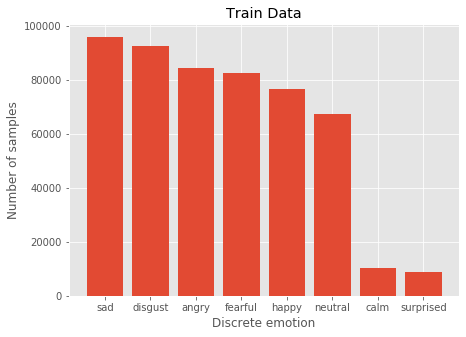

-0.80    95906
-0.41    92638
-0.20    84251
-0.40    82581
 0.80    76653
 0.00    67300
 0.50    10123
 0.30     8923
Name: X, dtype: int64


In [8]:
y_train_df = pd.DataFrame(data=y_train, columns=['X','Y',])
y_train_plot = y_train_df['X'].value_counts()

barplot_labels = []

for coord in y_train_plot.keys():
    for key, value in circumplex_model.items():
        if coord == value[0][0]:
            barplot_labels.append(key)

y_pos = np.arange(len(barplot_labels))

plt.figure(figsize=(7,5))
plt.style.use('ggplot')

plt.bar(y_pos, y_train_plot)

plt.xticks(y_pos, barplot_labels)
plt.yticks()

plt.xlabel("Discrete emotion")
plt.ylabel("Number of samples")
plt.title("Train Data")
plt.show()
print(y_train_plot)

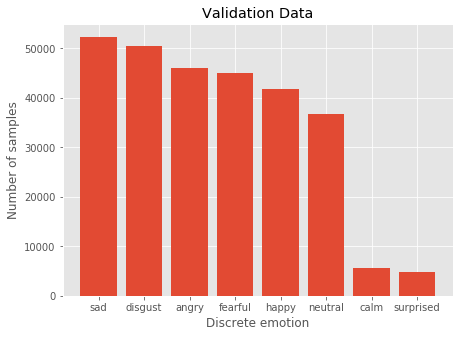

-0.80    52313
-0.41    50530
-0.20    45955
-0.40    45045
 0.80    41810
 0.00    36709
 0.50     5522
 0.30     4866
Name: X, dtype: int64


In [9]:
y_val_df = pd.DataFrame(data=y_val, columns=['X','Y',])
y_val_plot = y_val_df['X'].value_counts()

barplot_labels = []

for coord in y_val_plot.keys():
    for key, value in circumplex_model.items():
        if coord == value[0][0]:
            barplot_labels.append(key)

y_pos = np.arange(len(barplot_labels))

plt.figure(figsize=(7,5))
plt.style.use('ggplot')

plt.bar(y_pos, y_val_plot)

plt.xticks(y_pos, barplot_labels)
plt.yticks()
            
plt.xlabel("Discrete emotion")
plt.ylabel("Number of samples")
plt.title("Validation Data")
plt.show()
print(y_val_plot)

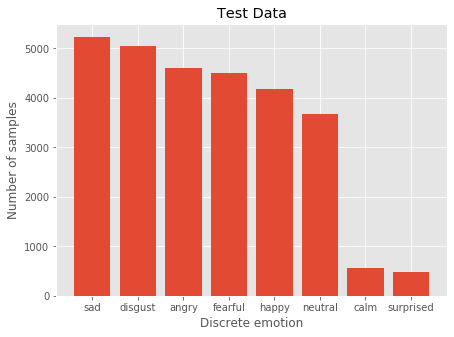

-0.80    5231
-0.41    5053
-0.20    4596
-0.40    4504
 0.80    4181
 0.00    3671
 0.50     552
 0.30     487
Name: X, dtype: int64


In [10]:
y_test_df = pd.DataFrame(data=y_test, columns=['X','Y',])
y_test_plot = y_test_df['X'].value_counts()

barplot_labels = []

for coord in y_test_plot.keys():
    for key, value in circumplex_model.items():
        if coord == value[0][0]:
            barplot_labels.append(key)

y_pos = np.arange(len(barplot_labels))

plt.figure(figsize=(7,5))
plt.style.use('ggplot')

plt.bar(y_pos, y_test_plot)

plt.xticks(y_pos, barplot_labels)
plt.yticks()

plt.annotate

plt.xlabel("Discrete emotion")
plt.ylabel("Number of samples")
plt.title("Test Data")
plt.show()
print(y_test_plot)

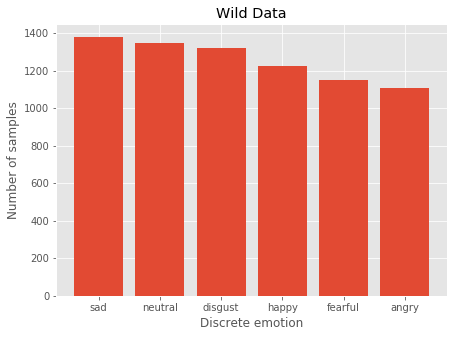

-0.80    1379
 0.00    1347
-0.41    1322
 0.80    1226
-0.40    1152
-0.20    1107
Name: X, dtype: int64


In [11]:
y_wild_df = pd.DataFrame(data=y_wild, columns=['X','Y',])
y_wild_plot = y_wild_df['X'].value_counts()

barplot_labels = []

for coord in y_wild_plot.keys():
    for key, value in circumplex_model.items():
        if coord == value[0][0]:
            barplot_labels.append(key)

y_pos = np.arange(len(barplot_labels))

plt.figure(figsize=(7,5))
plt.style.use('ggplot')

plt.bar(y_pos, y_wild_plot)

plt.xticks(y_pos, barplot_labels)
plt.yticks()

plt.xlabel("Discrete emotion")
plt.ylabel("Number of samples")
plt.title("Wild Data")
plt.show()
print(y_wild_plot)

# MLP PyTorch

In [12]:
class DataLoader(object):
    def __init__(self, x, y, batch_size, shuffle):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.start_idx = 0
        self.data_size = x.shape[0]
        if self.shuffle:
            self.reset()
    
    def reset(self):
        self.x, self.y = shuffle(self.x, self.y)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.start_idx >= self.data_size:
            if self.shuffle:
                self.reset()
            self.start_idx = 0
            raise StopIteration
    
        batch_x = self.x[self.start_idx:self.start_idx+self.batch_size]
        batch_y = self.y[self.start_idx:self.start_idx+self.batch_size]

        batch_x = torch.tensor(batch_x, dtype=torch.float, device=device)
        batch_y = torch.tensor(batch_y, dtype=torch.float, device=device)

        self.start_idx += self.batch_size

        return (batch_x, batch_y)

In [13]:
train_loader = DataLoader(X_train, y_train,
                 batch_size=256,
                 shuffle=False)

val_loader = DataLoader(X_val, y_val,
                 batch_size=256,
                 shuffle=False)

print("Train Set:")
# checking the dataset
for features, labels in train_loader:  
    print('Features Dimensions:', features.shape)
    print('label dimensions:', labels.shape)
    break
    
# checking the dataset
print("Validation Set:")
for features, labels in val_loader:  
    print('Features dimensions:', features.shape)
    print('Label dimensions:', labels.shape)
    break

Train Set:
Features Dimensions: torch.Size([256, 39])
label dimensions: torch.Size([256, 2])
Validation Set:
Features dimensions: torch.Size([256, 39])
Label dimensions: torch.Size([256, 2])


In [14]:
#defining model
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim_1, hidden_dim_2, out_dim=2):
        super(MLP, self).__init__()
        
        self.in_dim = in_dim
        self.hidden_dim_1 = hidden_dim_1
        self.hidden_dim_2 = hidden_dim_2
        self.out_dim = out_dim
        
        ## 1st hidden layer
        self.linear_1 = nn.Linear(self.in_dim, self.hidden_dim_1)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        self.linear_1_bn = nn.BatchNorm1d(self.hidden_dim_1,momentum=0.6)
        
        ## 2nd hidden layer
        self.linear_2 = nn.Linear(self.hidden_dim_1, self.hidden_dim_2)
        self.linear_2.weight.detach().normal_(0.0, 0.1)
        self.linear_2.bias.detach().zero_()
        self.linear_2_bn = nn.BatchNorm1d(self.hidden_dim_2,momentum=0.6)
        
        ## Out layer
        self.linear_out = nn.Linear(self.hidden_dim_2, self.out_dim)
        self.linear_out.weight.detach().normal_(0.0, 0.1)
        self.linear_out.bias.detach().zero_()
        
    def forward(self, x):
        out = self.linear_1(x)
        out = self.linear_1_bn(out)
        out = F.relu(out)
        
        out = self.linear_2(out)
        out = self.linear_2_bn(out)
        out = F.relu(out)
        out = F.dropout(out, p=0.175, training=self.training)
        
        out = self.linear_out(out)
        return out

In [15]:
#init model
mlp = MLP(39, 300, 150, 2).to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

In [16]:
# training phase
epochs = 100

# to plot loss curve after training
valid_losses = []
#losses = []

for epoch in range(epochs):
    start_time = time.time()
    mlp.train()
    num_batch = train_loader.data_size // train_loader.batch_size + 1
    #train_loss_epoch = 0
    
    for batch_id, (batch_x, batch_y) in enumerate(train_loader):
        
        y_pred = mlp(batch_x)
        loss = F.mse_loss(y_pred, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        elapsed_time = time.time() - start_time
        elapsed_min = int(elapsed_time / 60)
        elapsed_sec = elapsed_time - 60 * elapsed_min
        
        #train_loss_epoch += loss.item()

        print('\rEpoch:{} Batch:{}/{} Loss:{:.4f} Time:{}m{:.2f}s'.format(epoch + 1, batch_id, 
                                                                          num_batch, loss.item(),
                                                                          elapsed_min, elapsed_sec), end='')
    print()
    
    #train_loss_epoch /= num_batch
    #losses.append(train_loss_epoch)
    
    mlp.eval()
    valid_loss = 0
    best_loss = np.inf
    num_batch = val_loader.data_size // val_loader.batch_size + 1
    
    for batch_id, (batch_x, batch_y) in enumerate(val_loader):
        
        y_pred = mlp(batch_x)
        loss = F.mse_loss(y_pred, batch_y)
        valid_loss += loss.item()
    
    valid_loss /= num_batch
    valid_losses.append(valid_loss)
    
    #save model when validation loss is minimum
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(mlp.state_dict(), 'mlp.bestmodel') 
    
    print('Valid Loss:{:.4f}'.format(valid_loss))

Epoch:1 Batch:2023/2025 Loss:0.1897 Time:0m26.52s
Valid Loss:0.1808
Epoch:2 Batch:2024/2025 Loss:0.1845 Time:0m26.16s
Valid Loss:0.1776
Epoch:3 Batch:2024/2025 Loss:0.1841 Time:0m25.72s
Valid Loss:0.1746
Epoch:4 Batch:2024/2025 Loss:0.1805 Time:0m26.50s
Valid Loss:0.1718
Epoch:5 Batch:2024/2025 Loss:0.1797 Time:0m26.12s
Valid Loss:0.1692
Epoch:6 Batch:2024/2025 Loss:0.1781 Time:0m29.16s
Valid Loss:0.1671
Epoch:7 Batch:2024/2025 Loss:0.1740 Time:0m26.50s
Valid Loss:0.1654
Epoch:8 Batch:2024/2025 Loss:0.1714 Time:0m26.25s
Valid Loss:0.1636
Epoch:9 Batch:2024/2025 Loss:0.1726 Time:0m25.78s
Valid Loss:0.1622
Epoch:10 Batch:2024/2025 Loss:0.1692 Time:0m25.34s
Valid Loss:0.1611
Epoch:11 Batch:2024/2025 Loss:0.1719 Time:0m25.53s
Valid Loss:0.1600
Epoch:12 Batch:2024/2025 Loss:0.1641 Time:0m26.32s
Valid Loss:0.1590
Epoch:13 Batch:2024/2025 Loss:0.1666 Time:0m28.55s
Valid Loss:0.1580
Epoch:14 Batch:2024/2025 Loss:0.1740 Time:0m26.34s
Valid Loss:0.1572
Epoch:15 Batch:2024/2025 Loss:0.1714 Time:0

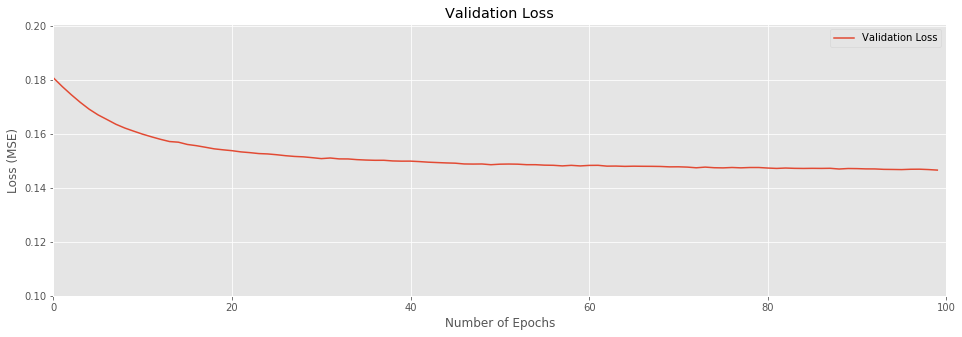

minimum validation loss is 0.1466


In [17]:
# plot validation loss curve
plt.figure(figsize=(16,5))
plt.title("Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss (MSE)")
plt.ylim(0.1,max(valid_losses)+0.02)
plt.xlim(0,epochs)
plt.style.use('ggplot')
plt.plot(valid_losses, label='Validation Loss')
#plt.plot(losses, label='Training Loss')
plt.legend()
plt.show()
#print(losses[0])
print('minimum validation loss is {:.4f}'.format(min(valid_losses)))

## Testing

In [18]:
#load the best model
mlp.load_state_dict(torch.load('mlp.bestmodel'))

<All keys matched successfully>

In [19]:
#predict train
x_train = torch.tensor(X_train, dtype=torch.float, device=device)

y_pred = mlp(x_train)
y_pred = y_pred.data.cpu().numpy()

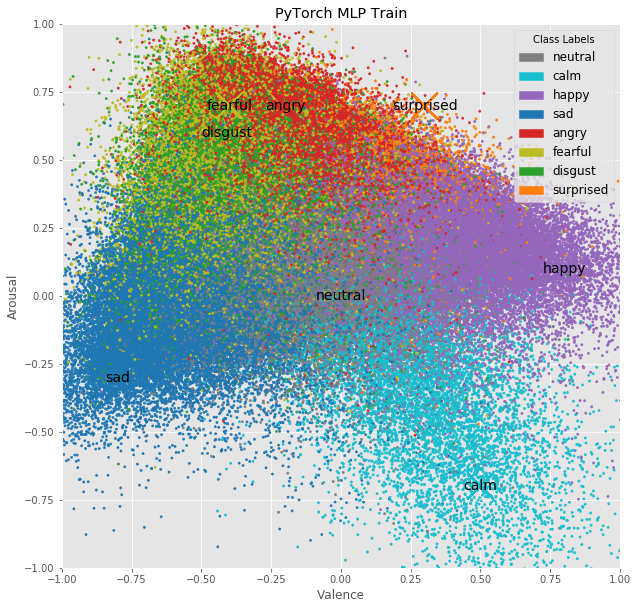

        True x  True y    Pred x    Pred y
0         -0.4     0.7  0.152467  0.326187
1          0.8     0.1  0.077358  0.226194
2         -0.2     0.7 -0.470069  0.628588
3         -0.2     0.7 -0.038109  0.567974
4         -0.4     0.7 -0.293495  0.430242
...        ...     ...       ...       ...
518370    -0.8    -0.3 -0.418898  0.068794
518371     0.0     0.0 -0.491455 -0.191627
518372     0.0     0.0 -0.553349  0.108266
518373    -0.2     0.7 -0.430263  0.785452
518374     0.8     0.1 -0.119214  0.349394

[518375 rows x 4 columns]

Mean Absolute Error: 0.28542359094272707
Mean Squared Error: 0.12692255290275345
Root Mean Squared Error: 0.3562619161554508


In [20]:
# plotting train
fontP = FontProperties()
fontP.set_size('large')

plt.figure(figsize=(10,10))
plt.title('PyTorch MLP Train')
# im = plt.imread("imshow/circumplex-model.png",0)
# implot = plt.imshow(im,extent=[y_train[:,0].min(),y_train[:,0].max(),y_train[:,1].min(),y_train[:,1].max()])

colors = []

for i in range(len(y_train)):
    for key, value in circumplex_model.items():
        if tuple(y_train[i]) == value[0]:
            colors.append(value[1])

plt.scatter(y_pred[:,0], y_pred[:,1], c=colors, s=5, marker='o')
plt.scatter(y_train[:,0], y_train[:,1], color=colors, s=650, marker='x')

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.xlabel("Valence")
plt.ylabel("Arousal")

plt.xticks()
plt.yticks()

# map emotion to dimensional model space
circumplex_model = {
    "neutral":[(0.0, 0.0),"tab:grey"],
    "calm":[(0.5, -0.7),"tab:cyan"], # only included in RAVDESS
    "happy":[(0.8, 0.1),"tab:purple"],
    "sad":[(-0.8, -0.3),"tab:blue"],
    "angry":[(-0.2, 0.7),"tab:red"],
    "fearful":[(-0.4, 0.7),"tab:olive"], #circumplex afraid
    "disgust":[(-0.41, 0.6),"tab:green"], #circumplex annoyed
    "surprised":[(0.3, 0.7),"tab:orange"], #circumplex astonished, in TESS specifies pleasant surprise
}

for key, value in circumplex_model.items():
    plt.annotate(key, value[0], ha='center', va='center', size=14)

# legend
grey_patch = mpatches.Patch(color='tab:grey', label='neutral')
cyan_patch = mpatches.Patch(color='tab:cyan', label='calm')
purple_patch = mpatches.Patch(color='tab:purple', label='happy')
blue_patch = mpatches.Patch(color='tab:blue', label='sad')
red_patch = mpatches.Patch(color='tab:red', label='angry')
olive_patch = mpatches.Patch(color='tab:olive', label='fearful')
green_patch = mpatches.Patch(color='tab:green', label='disgust')
orange_patch = mpatches.Patch(color='tab:orange', label='surprised')

plt.legend(title="Class Labels",handles=[
                    grey_patch,
                    cyan_patch,
                    purple_patch,
                    blue_patch,
                    red_patch,
                    olive_patch,
                    green_patch,
                    orange_patch],
#                     bbox_to_anchor=(1, 1),
                    prop=fontP)

plt.style.use('ggplot')
plt.show()

df_mlp_test = pd.DataFrame({'True x':y_train[:,0], 
                           'True y':y_train[:,1],
                           'Pred x':y_pred[:,0], 
                           'Pred y':y_pred[:,1]})

print(df_mlp_test)
print()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

In [21]:
#predict val
x_val = torch.tensor(X_val, dtype=torch.float, device=device)

y_pred = mlp(x_val)
y_pred = y_pred.data.cpu().numpy()

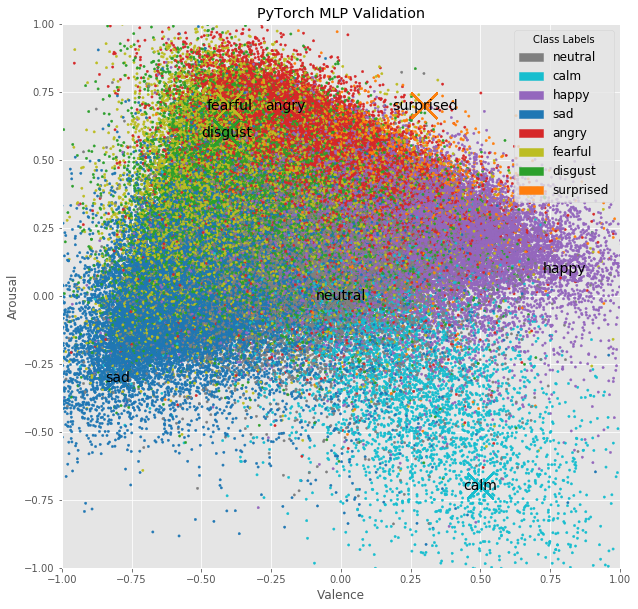

        True x  True y    Pred x    Pred y
0        -0.20     0.7  0.195978  0.344464
1        -0.80    -0.3 -0.129886  0.348856
2        -0.40     0.7 -0.497460  0.244628
3         0.50    -0.7  0.650284 -0.625955
4        -0.20     0.7 -0.345046  0.181483
...        ...     ...       ...       ...
282745   -0.20     0.7 -0.150846  0.502059
282746   -0.41     0.6 -0.591384 -0.004582
282747    0.80     0.1  0.050700  0.437482
282748    0.00     0.0  0.628723 -0.390001
282749    0.80     0.1  0.123589  0.393029

[282750 rows x 4 columns]

Mean Absolute Error: 0.3072138359874913
Mean Squared Error: 0.14663133809556664
Root Mean Squared Error: 0.3829247159632904


In [22]:
# plotting val
fontP = FontProperties()
fontP.set_size('large')

plt.figure(figsize=(10,10))
plt.title('PyTorch MLP Validation')
# im = plt.imread("imshow/circumplex-model.png",0)
# implot = plt.imshow(im,extent=[y_train[:,0].min(),y_train[:,0].max(),y_train[:,1].min(),y_train[:,1].max()])

colors = []

for i in range(len(y_val)):
    for key, value in circumplex_model.items():
        if tuple(y_val[i]) == value[0]:
            colors.append(value[1])

plt.scatter(y_pred[:,0], y_pred[:,1], c=colors, s=5, marker='o')
plt.scatter(y_val[:,0], y_val[:,1], color=colors, s=650, marker='x')

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.xlabel("Valence")
plt.ylabel("Arousal")

plt.xticks()
plt.yticks()

# map emotion to dimensional model space
circumplex_model = {
    "neutral":[(0.0, 0.0),"tab:grey"],
    "calm":[(0.5, -0.7),"tab:cyan"], # only included in RAVDESS
    "happy":[(0.8, 0.1),"tab:purple"],
    "sad":[(-0.8, -0.3),"tab:blue"],
    "angry":[(-0.2, 0.7),"tab:red"],
    "fearful":[(-0.4, 0.7),"tab:olive"], #circumplex afraid
    "disgust":[(-0.41, 0.6),"tab:green"], #circumplex annoyed
    "surprised":[(0.3, 0.7),"tab:orange"], #circumplex astonished, in TESS specifies pleasant surprise
}

for key, value in circumplex_model.items():
    plt.annotate(key, value[0], ha='center', va='center', size=14)

# legend
grey_patch = mpatches.Patch(color='tab:grey', label='neutral')
cyan_patch = mpatches.Patch(color='tab:cyan', label='calm')
purple_patch = mpatches.Patch(color='tab:purple', label='happy')
blue_patch = mpatches.Patch(color='tab:blue', label='sad')
red_patch = mpatches.Patch(color='tab:red', label='angry')
olive_patch = mpatches.Patch(color='tab:olive', label='fearful')
green_patch = mpatches.Patch(color='tab:green', label='disgust')
orange_patch = mpatches.Patch(color='tab:orange', label='surprised')

plt.legend(title="Class Labels",handles=[
                    grey_patch,
                    cyan_patch,
                    purple_patch,
                    blue_patch,
                    red_patch,
                    olive_patch,
                    green_patch,
                    orange_patch],
#                     bbox_to_anchor=(1, 1),
                    prop=fontP)

plt.style.use('ggplot')
plt.show()

df_mlp_test = pd.DataFrame({'True x':y_val[:,0], 
                           'True y':y_val[:,1],
                           'Pred x':y_pred[:,0], 
                           'Pred y':y_pred[:,1]})

print(df_mlp_test)
print()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred)))

In [23]:
# test data from initial split 
x_test = torch.tensor(X_test, dtype=torch.float, device=device)

#predict
y_pred = mlp(x_test)
y_pred = y_pred.data.cpu().numpy()

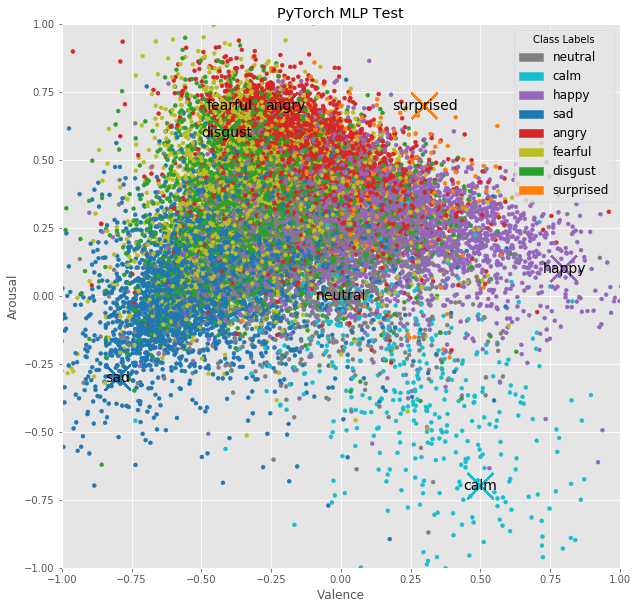

       True x  True y    Pred x    Pred y
0       -0.41     0.6 -0.368486  0.192731
1       -0.41     0.6 -0.114425  0.405852
2        0.80     0.1  0.160481  0.391031
3       -0.41     0.6 -0.317331  0.676361
4       -0.20     0.7 -0.231856  0.466817
...       ...     ...       ...       ...
28270   -0.20     0.7 -0.018600  0.466492
28271   -0.40     0.7 -0.019281  0.398497
28272    0.00     0.0 -0.328093  0.216301
28273    0.80     0.1 -0.062753  0.093960
28274    0.00     0.0  0.164795  0.345859

[28275 rows x 4 columns]

Mean Absolute Error: 0.3063413471079358
Mean Squared Error: 0.14635698352693507
Root Mean Squared Error: 0.38256631258768076


In [24]:
# plotting test
fontP = FontProperties()
fontP.set_size('large')

plt.figure(figsize=(10,10))
plt.title('PyTorch MLP Test')
# im = plt.imread("imshow/circumplex-model.png",0)
# implot = plt.imshow(im,extent=[y_train[:,0].min(),y_train[:,0].max(),y_train[:,1].min(),y_train[:,1].max()])

colors = []

for i in range(len(y_test)):
    for key, value in circumplex_model.items():
        if tuple(y_test[i]) == value[0]:
            colors.append(value[1])

plt.scatter(y_pred[:,0], y_pred[:,1], c=colors, s=15, marker='o')
plt.scatter(y_test[:,0], y_test[:,1], color=colors, s=650, marker='x')

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.xlabel("Valence")
plt.ylabel("Arousal")

plt.xticks()
plt.yticks()

# map emotion to dimensional model space
circumplex_model = {
    "neutral":[(0.0, 0.0),"tab:grey"],
    "calm":[(0.5, -0.7),"tab:cyan"], # only included in RAVDESS
    "happy":[(0.8, 0.1),"tab:purple"],
    "sad":[(-0.8, -0.3),"tab:blue"],
    "angry":[(-0.2, 0.7),"tab:red"],
    "fearful":[(-0.4, 0.7),"tab:olive"], #circumplex afraid
    "disgust":[(-0.41, 0.6),"tab:green"], #circumplex annoyed
    "surprised":[(0.3, 0.7),"tab:orange"], #circumplex astonished, in TESS specifies pleasant surprise
}

for key, value in circumplex_model.items():
    plt.annotate(key, value[0], ha='center', va='center', size=14)

# legend
grey_patch = mpatches.Patch(color='tab:grey', label='neutral')
cyan_patch = mpatches.Patch(color='tab:cyan', label='calm')
purple_patch = mpatches.Patch(color='tab:purple', label='happy')
blue_patch = mpatches.Patch(color='tab:blue', label='sad')
red_patch = mpatches.Patch(color='tab:red', label='angry')
olive_patch = mpatches.Patch(color='tab:olive', label='fearful')
green_patch = mpatches.Patch(color='tab:green', label='disgust')
orange_patch = mpatches.Patch(color='tab:orange', label='surprised')

plt.legend(title="Class Labels",handles=[
                    grey_patch,
                    cyan_patch,
                    purple_patch,
                    blue_patch,
                    red_patch,
                    olive_patch,
                    green_patch,
                    orange_patch],
#                     bbox_to_anchor=(1, 1),
                    prop=fontP)

plt.style.use('ggplot')
plt.show()

df_mlp_test = pd.DataFrame({'True x':y_test[:,0], 
                           'True y':y_test[:,1],
                           'Pred x':y_pred[:,0], 
                           'Pred y':y_pred[:,1]})

print(df_mlp_test)
print()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [25]:
# wild test data
x_wild = torch.tensor(X_wild, dtype=torch.float, device=device)

#predict
y_pred = mlp(x_wild)
y_pred = y_pred.data.cpu().numpy()

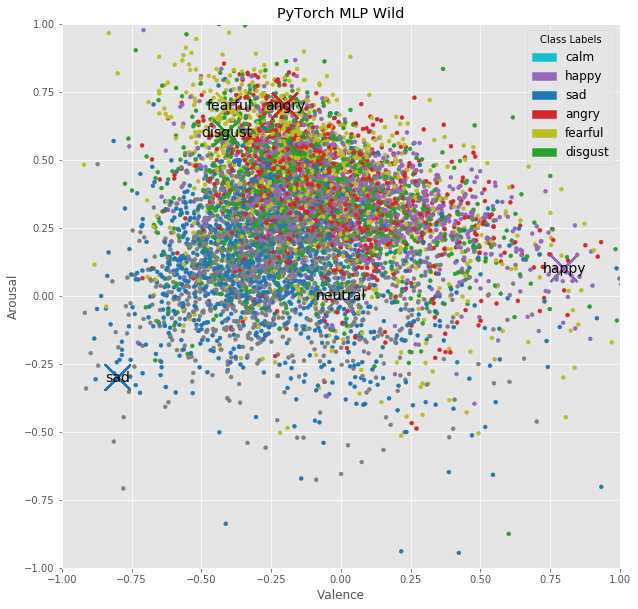

      True x  True y    Pred x    Pred y
0      -0.40     0.7 -0.212507  0.270150
1       0.00     0.0 -0.225385  0.516079
2      -0.41     0.6  0.165143  0.209084
3      -0.20     0.7 -0.394117  0.646167
4      -0.41     0.6 -0.032877  0.379971
...      ...     ...       ...       ...
7528   -0.80    -0.3 -0.639958  0.070748
7529   -0.40     0.7 -0.324410  0.655387
7530    0.80     0.1 -0.102069  0.308136
7531   -0.20     0.7 -0.452535  0.411800
7532    0.00     0.0 -0.110871  0.347984

[7533 rows x 4 columns]

Mean Absolute Error: 0.36558976156205875
Mean Squared Error: 0.2087684428557786
Root Mean Squared Error: 0.4569118545800476


In [26]:
# plotting wild
fontP = FontProperties()
fontP.set_size('large')

plt.figure(figsize=(10,10))
plt.title('PyTorch MLP Wild')
# im = plt.imread("imshow/circumplex-model.png",0)
# implot = plt.imshow(im,extent=[y_train[:,0].min(),y_train[:,0].max(),y_train[:,1].min(),y_train[:,1].max()])

colors = []

for i in range(len(y_wild)):
    for key, value in circumplex_model.items():
        if tuple(y_wild[i]) == value[0]:
            colors.append(value[1])

plt.scatter(y_pred[:,0], y_pred[:,1], c=colors, s=15, marker='o')
plt.scatter(y_wild[:,0], y_wild[:,1], color=colors, s=650, marker='x')

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.xlabel("Valence")
plt.ylabel("Arousal")

plt.xticks()
plt.yticks()

# map emotion to dimensional model space
circumplex_model = {
    "neutral":[(0.0, 0.0),"tab:grey"],
    #"calm":[(0.5, -0.7),"tab:cyan"], # only included in RAVDESS
    "happy":[(0.8, 0.1),"tab:purple"],
    "sad":[(-0.8, -0.3),"tab:blue"],
    "angry":[(-0.2, 0.7),"tab:red"],
    "fearful":[(-0.4, 0.7),"tab:olive"], #circumplex afraid
    "disgust":[(-0.41, 0.6),"tab:green"], #circumplex annoyed
    #"surprised":[(0.3, 0.7),"tab:orange"], #circumplex astonished, in TESS specifies pleasant surprise
}

for key, value in circumplex_model.items():
    plt.annotate(key, value[0], ha='center', va='center', size=14)

# legend
grey_patch = mpatches.Patch(color='tab:grey', label='neutral')
cyan_patch = mpatches.Patch(color='tab:cyan', label='calm')
purple_patch = mpatches.Patch(color='tab:purple', label='happy')
blue_patch = mpatches.Patch(color='tab:blue', label='sad')
red_patch = mpatches.Patch(color='tab:red', label='angry')
olive_patch = mpatches.Patch(color='tab:olive', label='fearful')
green_patch = mpatches.Patch(color='tab:green', label='disgust')
orange_patch = mpatches.Patch(color='tab:orange', label='surprised')

plt.legend(title="Class Labels",handles=[
#                     grey_patch,
                    cyan_patch,
                    purple_patch,
                    blue_patch,
                    red_patch,
                    olive_patch,
                    green_patch],
#                     orange_patch],
#                     bbox_to_anchor=(1, 1),
                    prop=fontP)

plt.style.use('ggplot')
plt.show()

df_mlp_wild = pd.DataFrame({'True x':y_wild[:,0], 
                           'True y':y_wild[:,1],
                           'Pred x':y_pred[:,0], 
                           'Pred y':y_pred[:,1]})

print(df_mlp_wild)
print()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_wild, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_wild, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_wild, y_pred)))

# Sklearn MLPRegressor and RandomForestRegressor

In [ ]:
mlp_params = {
    'batch_size': 256,
    'epsilon': 1e-08, 
    'hidden_layer_sizes': (300,150), 
    'learning_rate': 'adaptive', 
    'max_iter': 100, 
    'verbose':1,
    'n_iter_no_change':None,
    'early_stopping':True,
    'random_state':420,
}

In [ ]:
mlp = MLPRegressor(**mlp_params)
mlp.out_activation_ = 'logistic'
mlp.fit(X_train, y_train)

In [ ]:
y_predict_mlp = mlp.predict(X_test)

In [ ]:
rfr_params = {
    'verbose': 10,
    'n_estimators': 100,
    'max_depth': None,
    'random_state': 420,
    'min_samples_split': 4,
    'min_samples_leaf': 3,
}

In [ ]:
# init regr
rfr = RandomForestRegressor(**rfr_params)

In [ ]:
# train the model
print("[*] Training the model...")
rfr.fit(X_train, y_train)

In [ ]:
y_predict_rfr = rfr.predict(X_test)

In [ ]:
# plotting
plt.figure(figsize=(10,10))
plt.title('RandomForestRegressor')
# im = plt.imread("imshow/circumplex-model.png",0)
# implot = plt.imshow(im,extent=[y_train[:,0].min(),y_train[:,0].max(),y_train[:,1].min(),y_train[:,1].max()])

colors = []

for i in range(len(y_test)):
    for key, value in circumplex_model.items():
        if tuple(y_test[i]) == value[0]:
            colors.append(value[1])

plt.scatter(y_test[:,0], y_test[:,1], color='black', s=15, marker='x')
plt.scatter(y_predict_rfr[:,0],y_predict_rfr[:,1], c=colors, s=15, marker='o')

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.xticks([])
plt.yticks([])

for key, value in circumplex_model.items():
    plt.annotate(key, value[0])

# legend
black_patch = mpatches.Patch(color='black', label='ground truth')
grey_patch = mpatches.Patch(color='grey', label='neutral')
cyan_patch = mpatches.Patch(color='cyan', label='calm')
purple_patch = mpatches.Patch(color='purple', label='happy')
blue_patch = mpatches.Patch(color='blue', label='sad')
red_patch = mpatches.Patch(color='red', label='angry')
magenta_patch = mpatches.Patch(color='magenta', label='fearful')
green_patch = mpatches.Patch(color='green', label='disgust')
orange_patch = mpatches.Patch(color='orange', label='surprised')

plt.legend(handles=[black_patch,
                    grey_patch,
                    cyan_patch,
                    purple_patch,
                    blue_patch,
                    red_patch,
                    magenta_patch,
                    green_patch,
                    orange_patch])

plt.show()

df_rfr = pd.DataFrame({'True x':y_test[:,0], 
                        'True y':y_test[:,1],
                        'Pred x':y_predict_rfr[:,0], 
                        'Pred y':y_predict_rfr[:,1]})
print(df_rfr)
print()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict_rfr))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict_rfr))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict_rfr)))

In [ ]:
# plotting
plt.figure(figsize=(10,10))
plt.title('MLPRegressor')
# im = plt.imread("imshow/circumplex-model.png",0)
# implot = plt.imshow(im,extent=[y_train[:,0].min(),y_train[:,0].max(),y_train[:,1].min(),y_train[:,1].max()])

colors = []

for i in range(len(y_test)):
    for key, value in circumplex_model.items():
        if tuple(y_test[i]) == value[0]:
            colors.append(value[1])

plt.scatter(y_test[:,0], y_test[:,1], color='black', s=15, marker='x')
plt.scatter(y_predict_mlp[:,0],y_predict_mlp[:,1], c=colors, s=15, marker='o')

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.xticks([])
plt.yticks([])

for key, value in circumplex_model.items():
    plt.annotate(key, value[0])

# legend
black_patch = mpatches.Patch(color='black', label='ground truth')
grey_patch = mpatches.Patch(color='grey', label='neutral')
cyan_patch = mpatches.Patch(color='cyan', label='calm')
purple_patch = mpatches.Patch(color='purple', label='happy')
blue_patch = mpatches.Patch(color='blue', label='sad')
red_patch = mpatches.Patch(color='red', label='angry')
magenta_patch = mpatches.Patch(color='magenta', label='fearful')
green_patch = mpatches.Patch(color='green', label='disgust')
orange_patch = mpatches.Patch(color='orange', label='surprised')

plt.legend(handles=[black_patch,
                    grey_patch,
                    cyan_patch,
                    purple_patch,
                    blue_patch,
                    red_patch,
                    magenta_patch,
                    green_patch,
                    orange_patch])

plt.show()

df_rfr = pd.DataFrame({'True x':y_test[:,0], 
                        'True y':y_test[:,1],
                        'Pred x':y_predict_mlp[:,0], 
                        'Pred y':y_predict_mlp[:,1]})
print(df_rfr)
print()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict_mlp))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict_mlp))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict_mlp)))

In [ ]:
# save the model
# make result directory if doesn't exist yet
if not os.path.isdir("result"):
    os.mkdir("result")

pickle.dump(rfr, open("result/rfr.model", "wb"))